# <div align="center">Logistic Regression in a Biased Loan Approval Dataset

### Continue working with loan_approval_biased dataset

In [44]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cbook
warnings.filterwarnings('ignore')

In [45]:
#read data
data = pd.read_csv("loan_approval_biased.csv")


### Taking a look at the data

In [46]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP002317,Male,Yes,3+,Graduate,No,81000,0.0,360,360,0,Rural,Y
1,LP002101,Male,Yes,0,Graduate,No,63337,0.0,490,180,1,Urban,Y
2,LP001536,Male,Yes,3+,Graduate,No,39999,0.0,600,180,0,Semiurban,Y
3,LP001640,Male,Yes,0,Graduate,Yes,39147,4750.0,120,360,1,Semiurban,Y
4,LP002422,Male,No,1,Graduate,No,37719,0.0,152,360,1,Semiurban,Y


In [47]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,156.050489,334.866450,0.812704
std,6109.041673,2926.248369,99.128597,79.599764,0.390467
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000
75%,5795.000000,2297.250000,175.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


### Basic EDA

                                             |          | [  0%]   00:00 -> (? left)


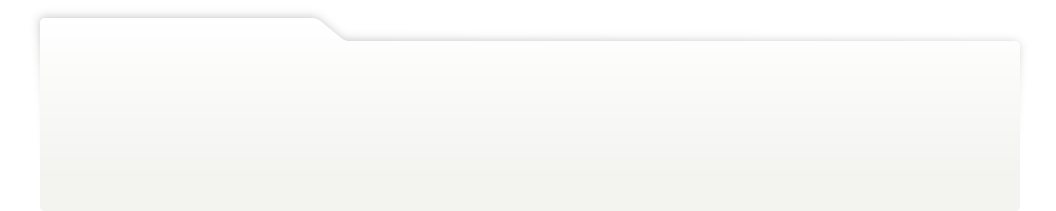
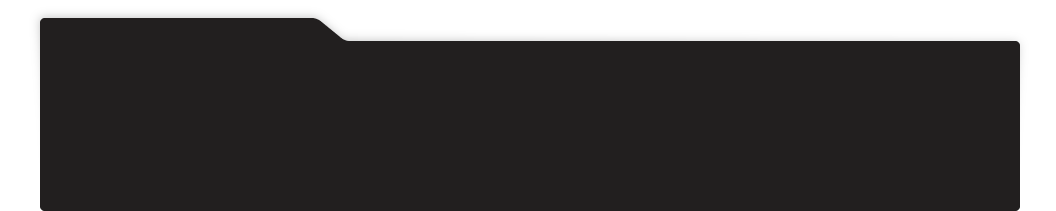
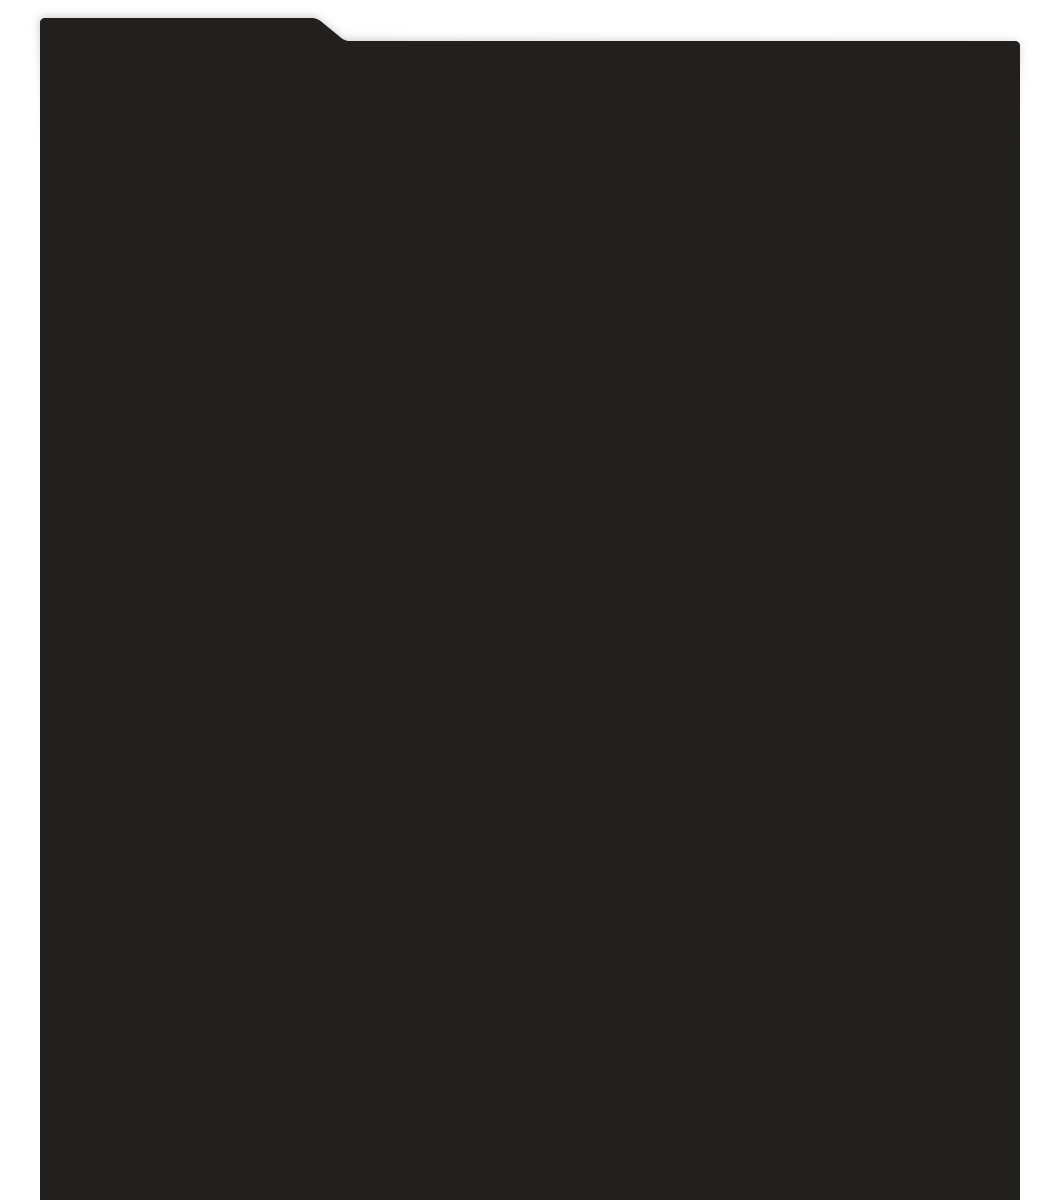
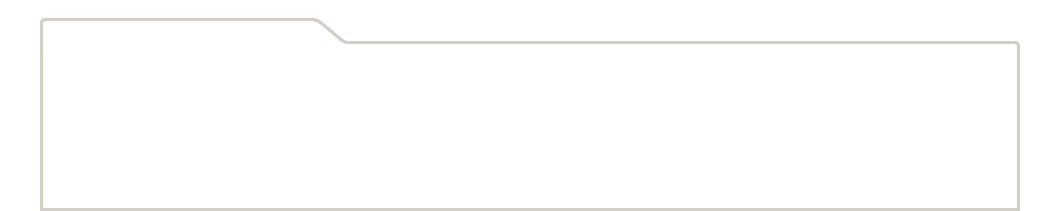
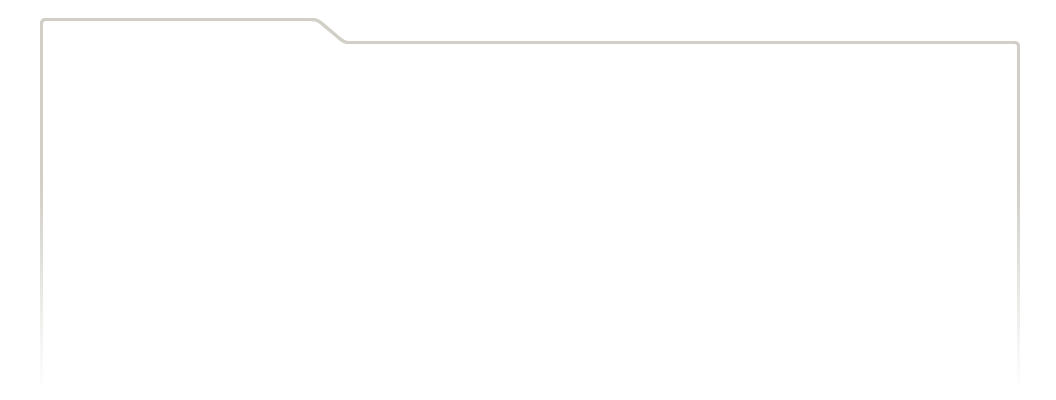
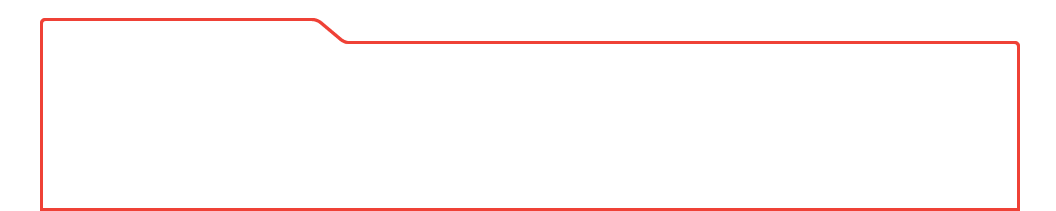
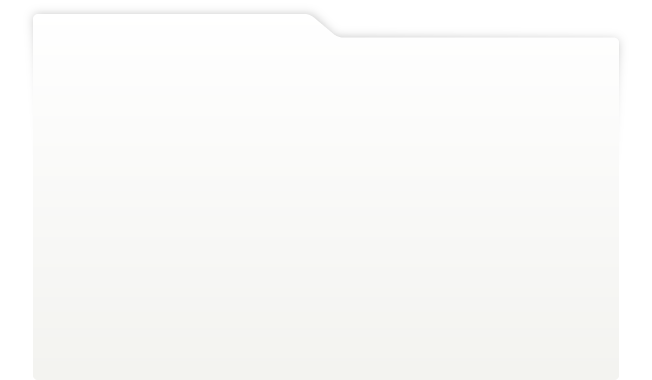
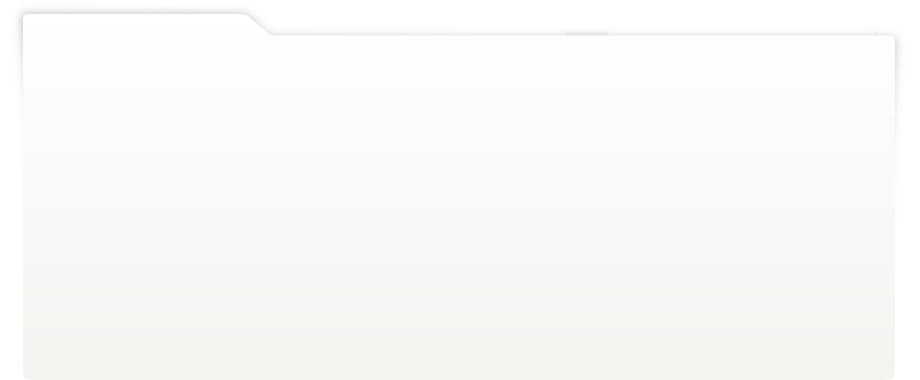
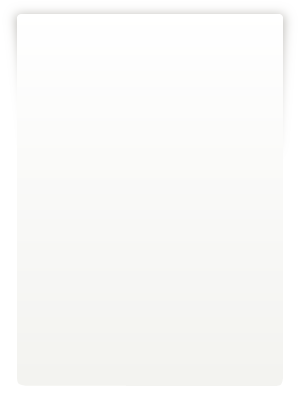
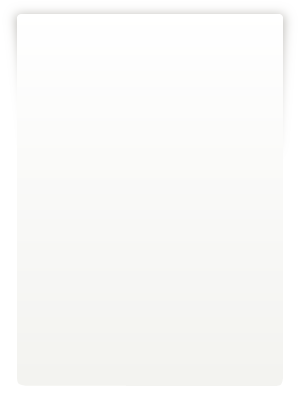
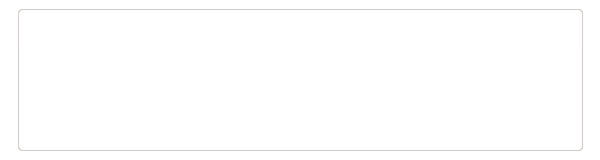
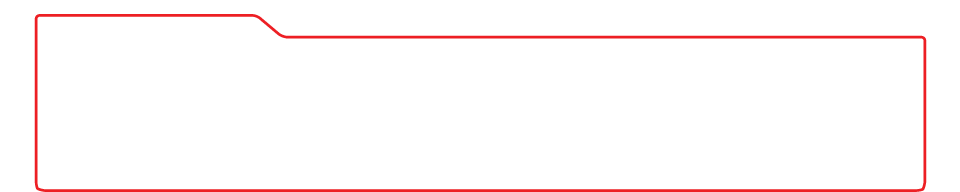
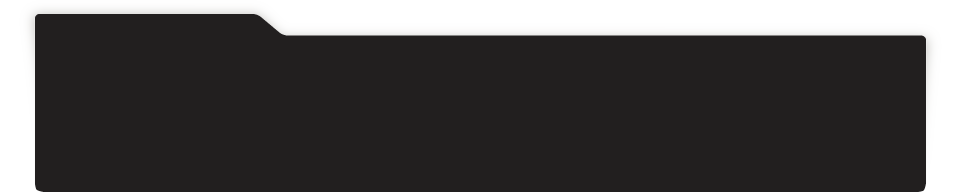
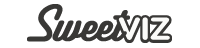
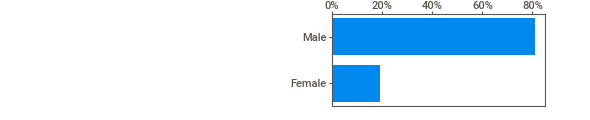
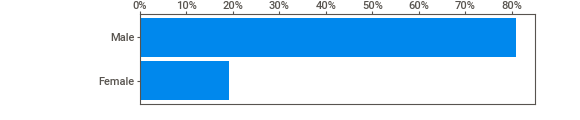
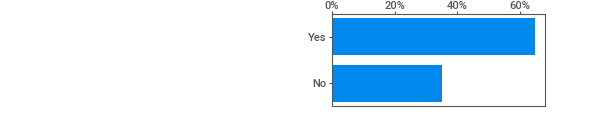
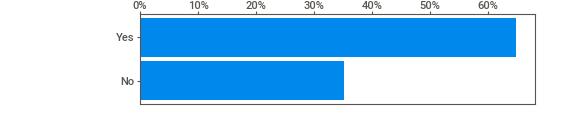
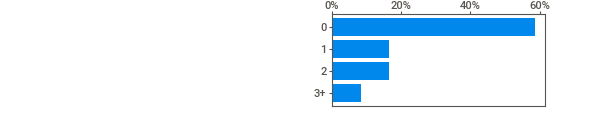
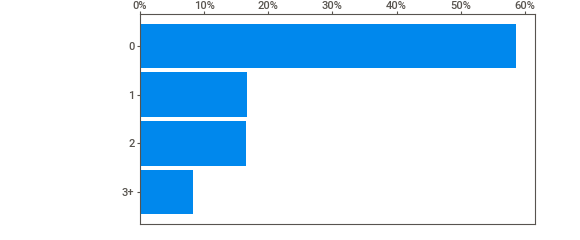
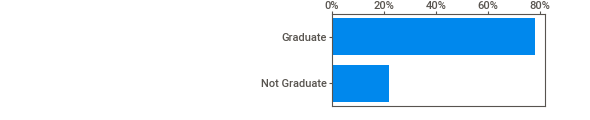
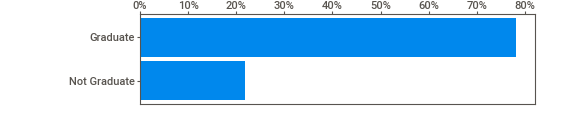
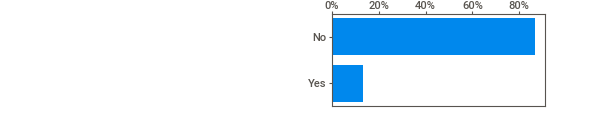
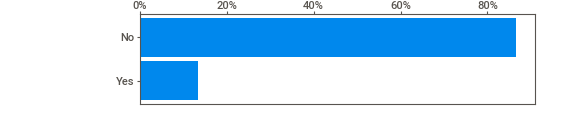
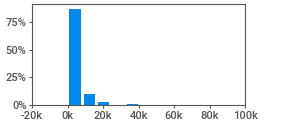
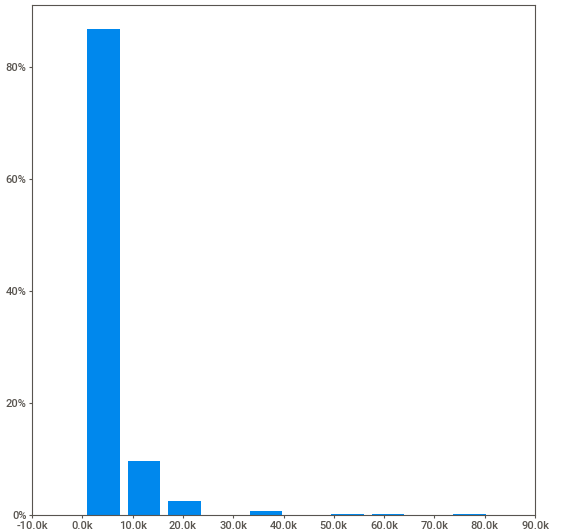
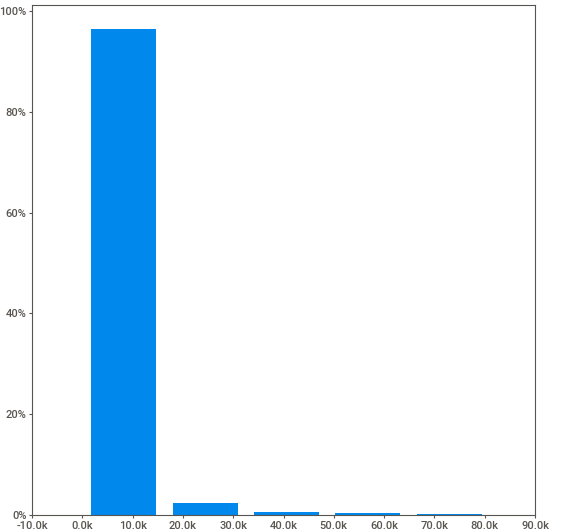
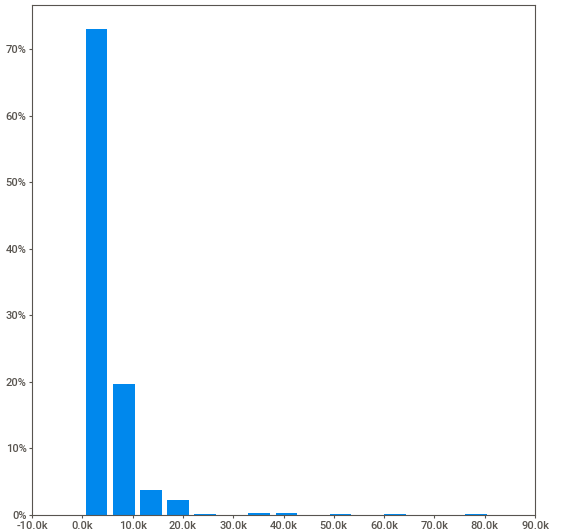
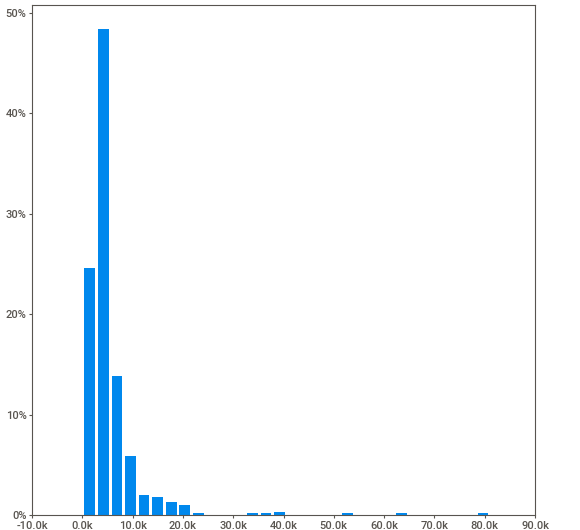
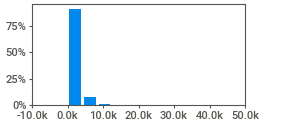
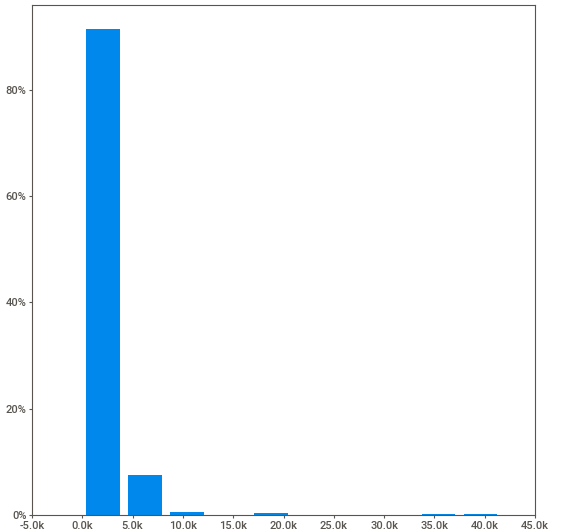
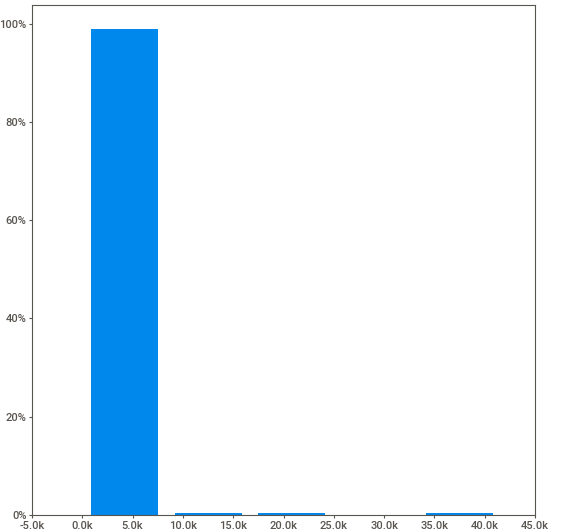
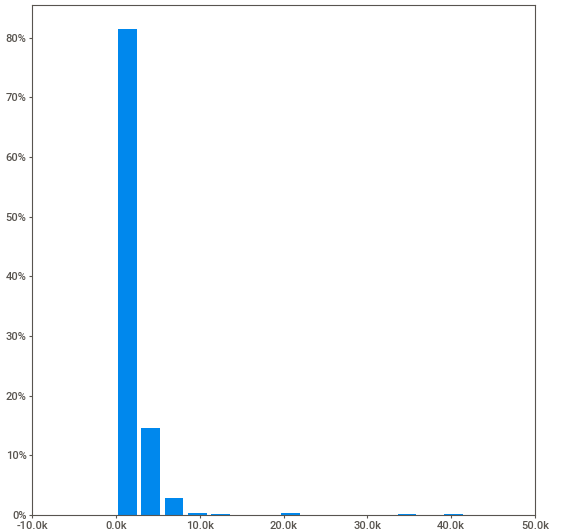
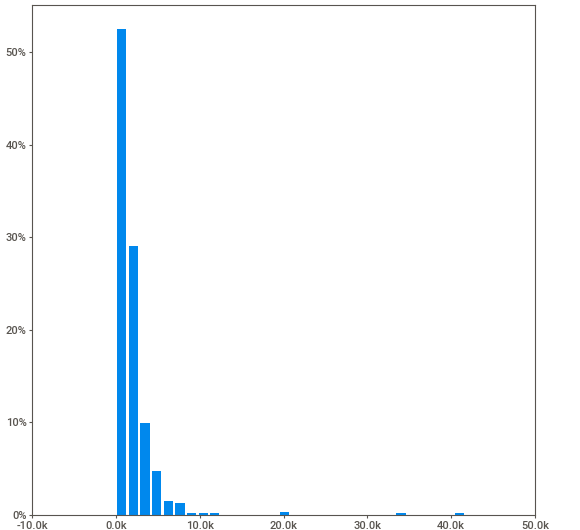
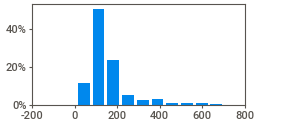
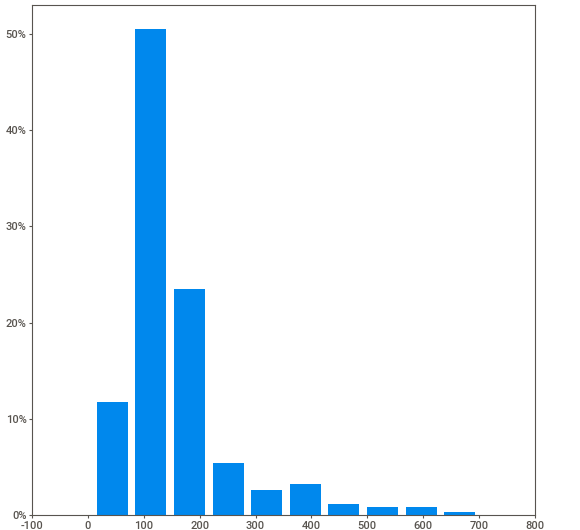
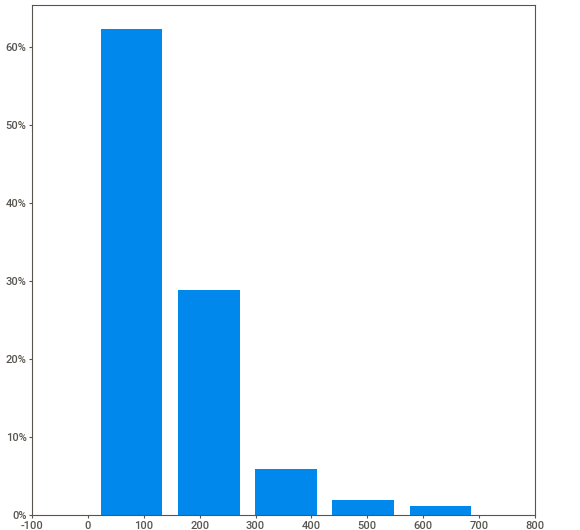
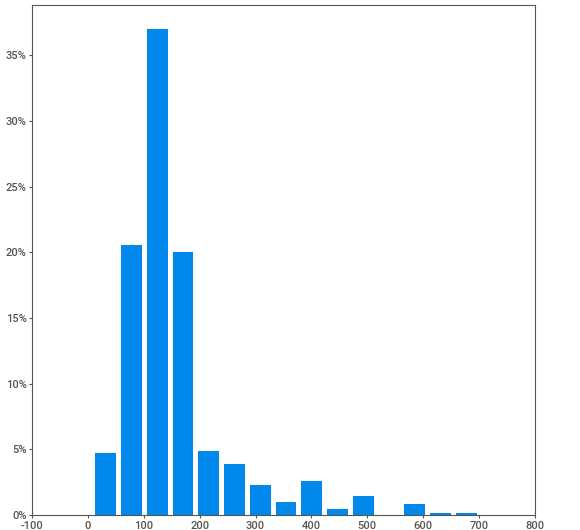
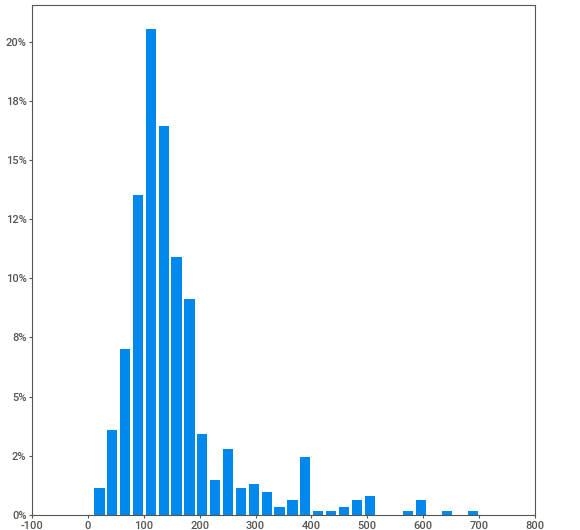
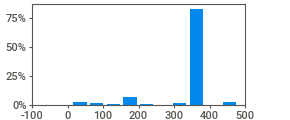
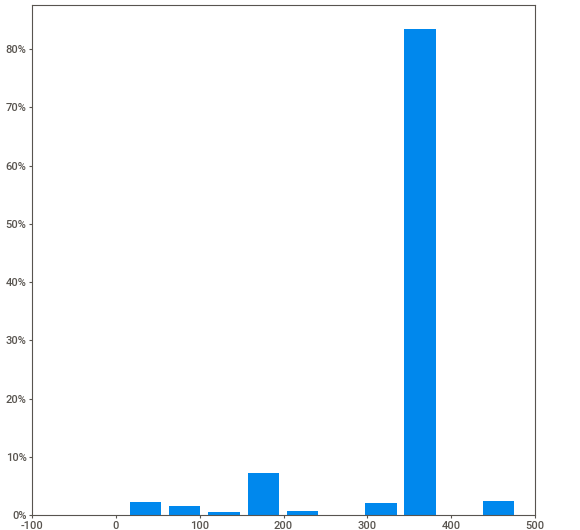
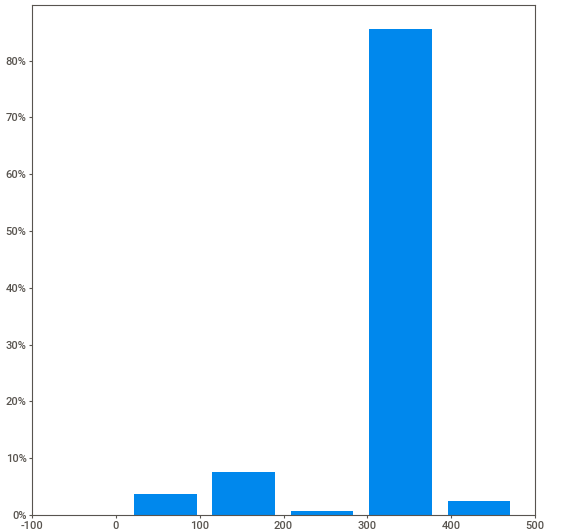
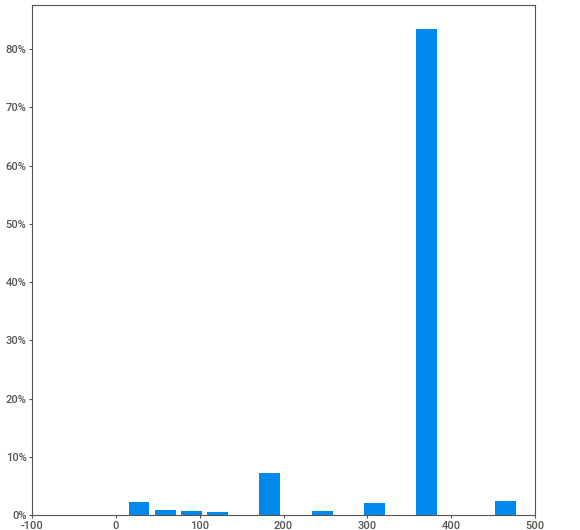
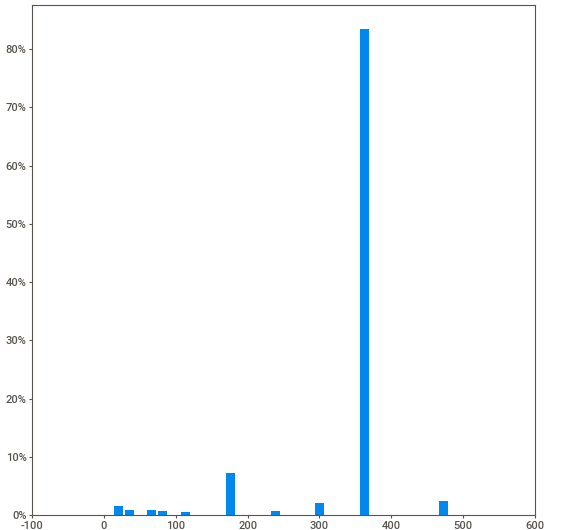
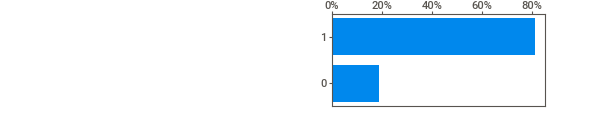
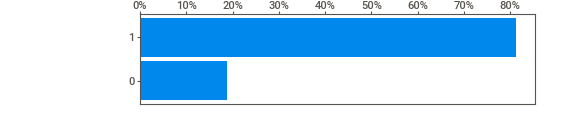
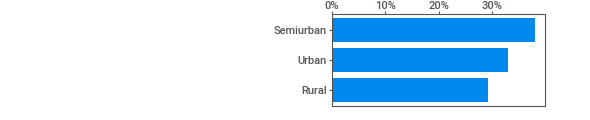
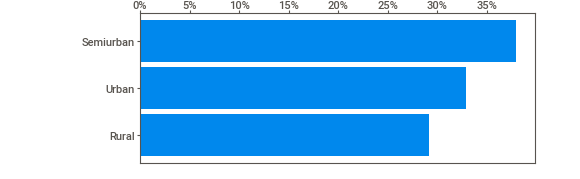
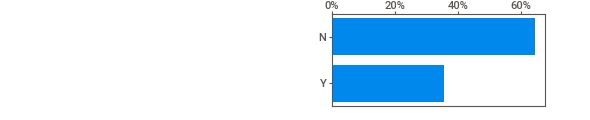
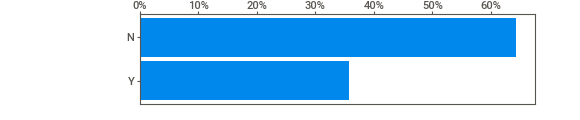
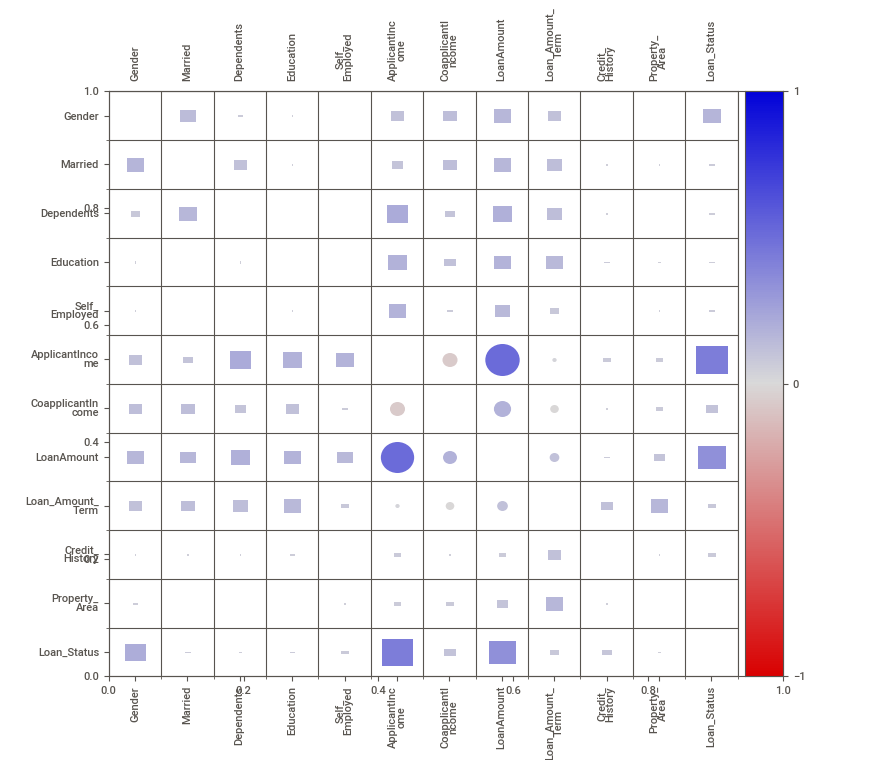
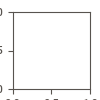

In [48]:
# Create the Sweetviz report
import sweetviz as sv

report = sv.analyze(data)
report.show_notebook()

### Encode Categorical Variables for Logistic Regression

In [49]:
# Assign data to df
df = pd.DataFrame(data)

# Columns to be encoded
label_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status', 'Dependents']

# Initialize label encoder
le = LabelEncoder()

# Dictionary to store the mappings
encoding_dict = {}

# Iterate through the columns and encode them
for col in label_columns:
    df[col] = le.fit_transform(df[col])
    
    # Store the mappings for this column in encoding_dict
    encoding_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Print out the mappings
for col, mappings in encoding_dict.items():
    print(f"\n{col}:")
    for original, encoded in mappings.items():
        print(f"{original} = {encoded}")



Gender:
Female = 0
Male = 1

Married:
No = 0
Yes = 1

Education:
Graduate = 0
Not Graduate = 1

Self_Employed:
No = 0
Yes = 1

Property_Area:
Rural = 0
Semiurban = 1
Urban = 2

Loan_Status:
N = 0
Y = 1

Dependents:
0 = 0
1 = 1
2 = 2
3+ = 3


### Perform Logistic Regression on the Biased Loan Approval Dataset

In [50]:
# Separate descriptive features from Loan_Status (target variable)
X = df.drop(columns=['Loan_ID', 'Loan_Status'])
y = df['Loan_Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a logistic regression model
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Predict the loan approval status on the test data
predictions = model.predict(X_test)

# Print the confusion matrix and classification report for evaluation
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[65  4]
 [18 36]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.86        69
           1       0.90      0.67      0.77        54

    accuracy                           0.82       123
   macro avg       0.84      0.80      0.81       123
weighted avg       0.83      0.82      0.82       123



### Using SHAP for explainability.

SHAP (SHapely Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapely values from game theory and their related extenions.

For more information, visit: https://shap.readthedocs.io/en/latest/

In [51]:
import shap

# Initialize JavaScript visualization library
shap.initjs()

In [52]:
#Create explainer object to compute SHAP values for predictions
#The explainer should be fitted on the training data. It is learning the patterns and relationships in the training
#dataset to understand how different features contribute to the prediction for each instance.

explainer = shap.KernelExplainer(model.predict_proba, X_train)


Using 491 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


### SHAP Force Plot

- Force plot visualization shows the impact of different features on the prediction of a single instance. 

- Each feature's contribution is represented as a force, either pushing the prediction higher (positive contribution) or lower (negative contribution) relative to the base value.

- Each feature is shown as a colored bar, with the color representing the feature's value (red for high and blue for low).

- The length of the bar represents the magnitude of the feature's impact on the prediction.

- If the bar extends to the right, that feature is pushing the prediction higher.

- If the bar extends to the left, that feature is pushing the prediction lower than the base value.

- The final prediction for the single instance is the sum of the average prediction of the model. 


In [53]:
print(np.array(shap_values).shape)

(123, 11)


In [54]:
print(shap_values[1][0].shape)

()


In [56]:
#Compute SHAP values based on test dataset
#Test data is used to explain the predictions that the model is making on unseen data 
#This allows us to see how well the model is generalizing.

#This may take a few minutes.

# Plot the SHAP values for first instance in test dataset
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0,:])

 ## <span style="color: green;">Task #1. </span>

Create a SHAP bar plot showing the global feature importance for approved loans.



### SHAP Bar Plot

Each bar will represent a feature with the total length of the bar representing the total impact of that feature across all predictions as an indicator of feature importance.

In [57]:
print(shap_values.shape)


(123, 11)


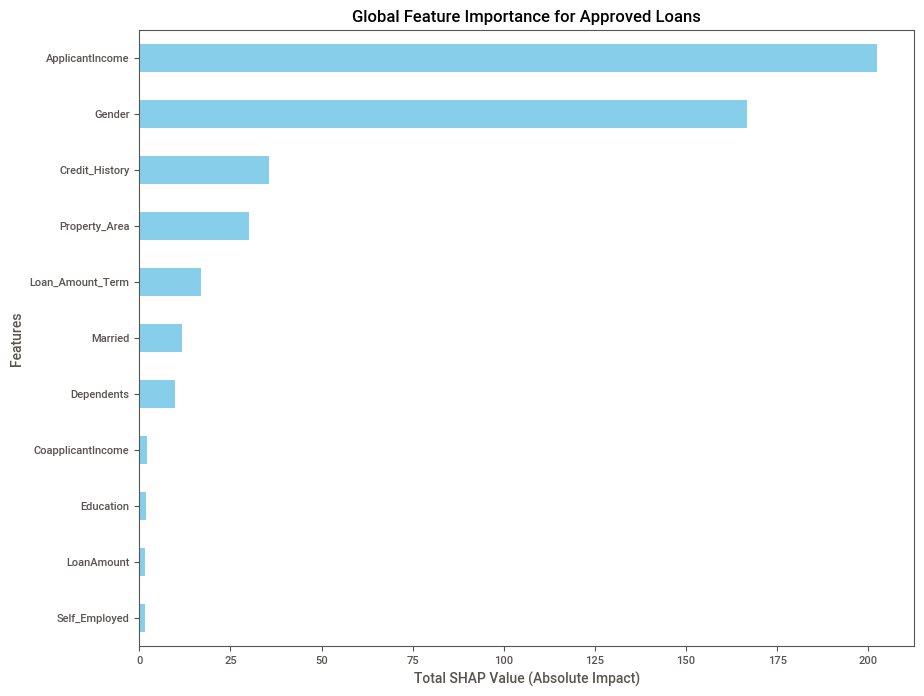

In [58]:
# Convert SHAP values to a DF

shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)


# Create bar plot to visualize global feature importance across all tested samples
global_feature_importance = shap_values_df.abs().sum().sort_values(ascending=True)

# Plot the global feature importance as a bar plot
global_feature_importance.plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.title('Global Feature Importance for Approved Loans')
plt.xlabel('Total SHAP Value (Absolute Impact)')
plt.ylabel('Features')
plt.show()


 ## <span style="color: green;">Task #2. </span>

Create a SHAP summary plot of feature impacts on approved loans.



### SHAP Summary Plot

Summary plot provides a comprehensive view of feature impacts:

- Feature importance: Features are ranked by importance with the most impactful features at the top.

- Value impact: Each dot represents a SHAP value for a specific feature and instance. The x-axis location shows the impact on the model output indicating whether the feature is pushing the prediction higher or lower.

- Feature value: The color of the dots represents the actual value of the feature, with red indicating higher values and blue indicating lower values to help understand how different feature values affect the prediction.

For example:
- Positive SHAP values: indicate features that p-ush the prediction towards approval
- Negative SHAP values: Indicate features that push the prediction towards denial.

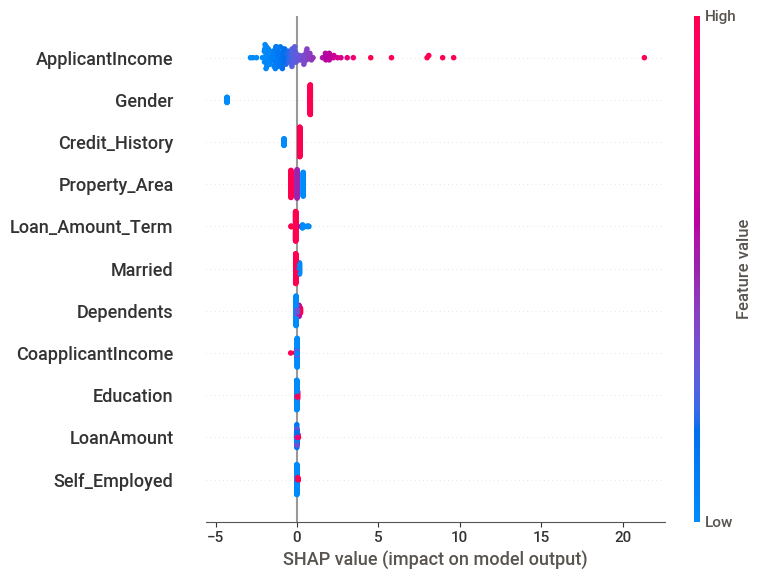

In [59]:
# Summary plot to show feature impacts on approved loans
shap.summary_plot(shap_values, X_test, plot_type="dot")

 ## <span style="color: green;">Task #3. </span>

Create a SHAP bar plot showing the global feature importance for denied loan approvals.



In [60]:
print(np.array(shap_values[1]).shape)

(11,)


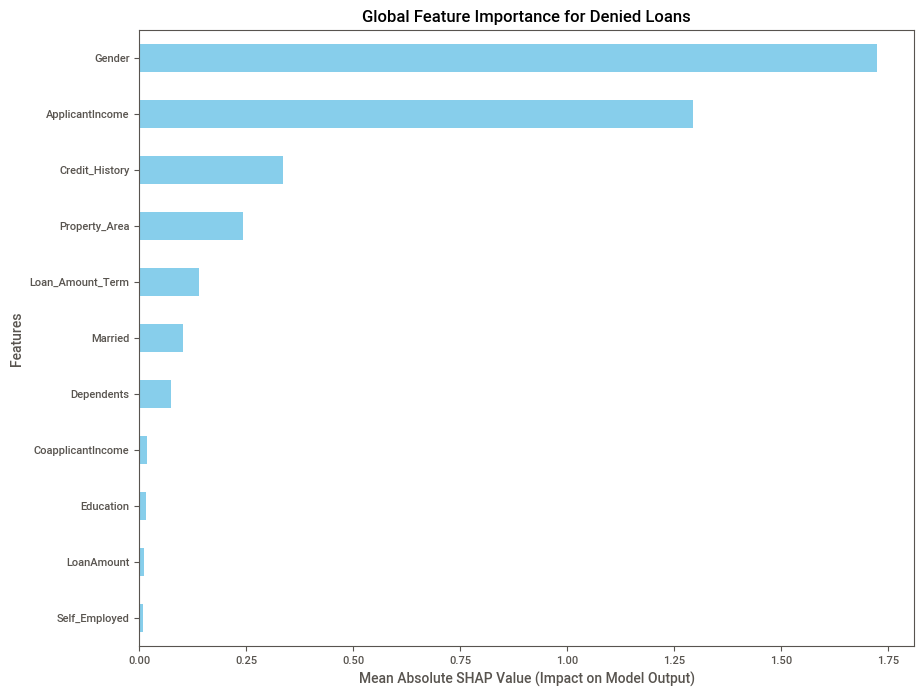

In [64]:
# Task #3: Denied Loans Bar Plot
shap_values_denied = shap_values[y_test == 0]  # Filter for instances with denied status
shap_values_denied_df = pd.DataFrame(shap_values_denied, columns=X_test.columns)
global_feature_importance_denied = shap_values_denied_df.abs().mean().sort_values(ascending=True)
global_feature_importance_denied.plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.title('Global Feature Importance for Denied Loans')
plt.xlabel('Mean Absolute SHAP Value (Impact on Model Output)')
plt.ylabel('Features')
plt.show()


 ## <span style="color: green;">Task #4. </span>

Create a SHAP waterfall bar plot for "Gender" on denial of loans. (x-axis should be gender (encoded) and y-axis should show the mean shap values for gender)



### SHAP Waterfall Bar Plot

- A positive SHAP value contributes to increasing the model's output value.
- A negative SHAP values contributes to decreasing the model's output value.

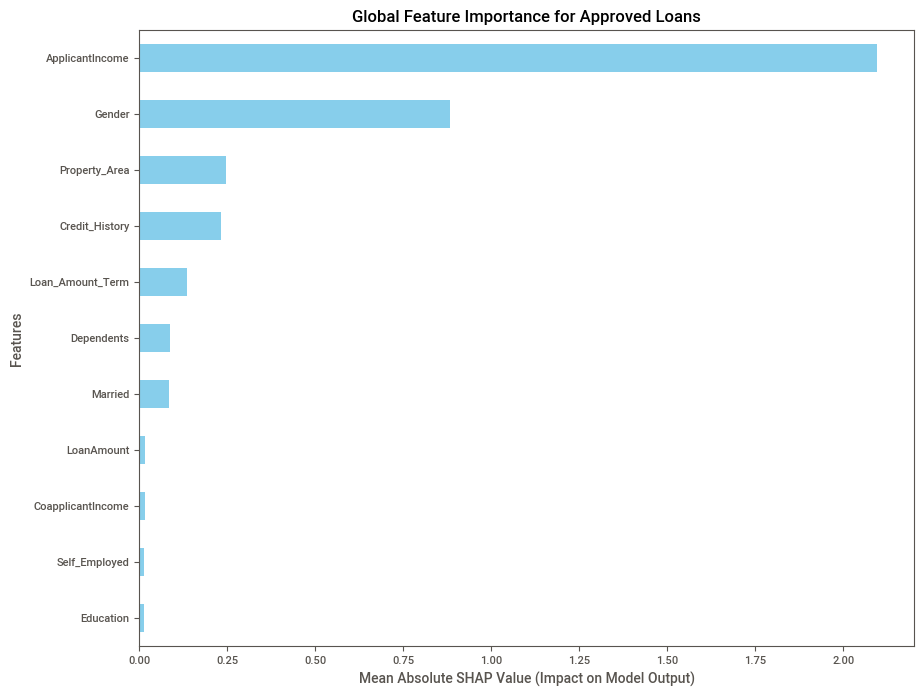

In [65]:
shap_values_approved = shap_values[y_test == 1]  # Filter for instances with approved status
shap_values_approved_df = pd.DataFrame(shap_values_approved, columns=X_test.columns)
global_feature_importance_approved = shap_values_approved_df.abs().mean().sort_values(ascending=True)
global_feature_importance_approved.plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.title('Global Feature Importance for Approved Loans')
plt.xlabel('Mean Absolute SHAP Value (Impact on Model Output)')
plt.ylabel('Features')
plt.show()

## <span style="color: green;">Short Response Questions: </span>

1. Given the SHAP force plot that you've generated, can you explain the role of each feature in influencing the model's prediction? Which features had the most significant positive and negative impacts? How did these values affect the overall predictions?


 #### <span style="color: green;">Question 1 Response: </span>
 
 

2. Through analysis of both local and global features, it is apparent that there is significant bias. After examining the various SHAP visualizations above, what did you observe for each one? Where is this bias originating? (i.e. Is the data not representative enough? Is the model biased?)

 #### <span style="color: green;">Question 2 Response: </span>

3. How would you adjust the logistic regression model to reduce bias and enhance fairness in predictions, and how would you validate the improvements?

 #### <span style="color: green;">Question 3 Response: </span>

4. Are there any other mitigation techniques (not necessarily pertaining to this particular dataset/model) that could be used to remove prejudice and bias?

 #### <span style="color: green;">Question 4 Response: </span>

5. How would you communicate the identified biases and proposed mitigation strategies to stakeholders to ensure transparency and ethical AI deployment?

#### <span style="color: green;">Question 5 Response: </span>